<center>
    <h1>ENSO Demo</h1>
    <h3>Part 1: Introduction and Data Preparation</h3>
</center>

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
DEGREE = '$^{\circ}$'

## Introduction

[El Ni&ntilde;o-Southern Oscillation (ENSO)](https://www.ncdc.noaa.gov/teleconnections/enso/) is a quasiperiodic fluctuation in <strong>sea surface temperatures (SSTs)</strong> and atmospheric pressure over the equatorial Pacific Ocean. It is characterized primarily by anomalously warm (El Ni&ntilde;o) or cool (La Ni&ntilde;a) SSTs in the central / Eastern equatorial Pacific, accompanied by bimodal variations in sea level pressure (Southern Oscillation) and many other changes in the coupled atmosphere-ocean system. These oscillations typically occur with a periodicity of about 2-7 years.

In this series of Jupyter notebooks, I will show how principal component analysis (PCA), spectral analysis, and other analytical techniques can provide insights into ENSO variability. These notebooks also demonstrate the [cartopy](http://scitools.org.uk/cartopy/) package for plotting geographic maps, and the [xarray](https://xarray.pydata.org/en/stable/) package for handling `netcdf` data files and easily stacking / unstacking dimensions to switch between 2-, 3-, and 4-dimensional views of the same array.

Part 1 of this series shows the initial stages of data preparation.

## Sea surface temperature data

For SSTs, I'm using [ERSST v.5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5) from NOAA, a dataset of SSTs reconstructed from historical measurements aboard ships (1880-1970s), and from marine and satellite measurements in the modern satellite era (1979-present). This is a gridded global dataset, with a resolution of 2$^{\circ}$ latitude $\times$ 2$^{\circ}$ longitude. I downloaded the data files (one per month for 1880-2016) with a bash script (`scripts/download_ersst.sh`) and merged the 1644 individual `netcdf` files into a single `netcdf` file with a Python script (`scripts/merge_ersst.py`). This merged file is the data we'll use in this notebook.

First, use the [xarray](https://xarray.pydata.org/en/stable/) package to load the `netcdf` data file into an `xarray.Dataset` variable. Then add `year` and `month` coordinates as a multiindex `time` dimension so that I can later unstack and stack these dimensions.

In [2]:
datafile = 'data/ERSST_v5_1880-2016.nc'
with xr.open_dataset(datafile) as ds:
    ds.load()

ds.coords['month'] = ds['time'].dt.month
ds.coords['year'] = ds['time'].dt.year
ds.coords['datetime'] = ds['time']
ds = ds.set_index(time=['month', 'year'])
ds

<xarray.Dataset>
Dimensions:   (lat: 89, lev: 1, lon: 180, time: 1644)
Coordinates:
  * lat       (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lev       (lev) float64 0.0
  * lon       (lon) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 ...
  * time      (time) MultiIndex
  - month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 ...
  - year      (time) int64 1880 1880 1880 1880 1880 1880 1880 1880 1880 1880 ...
    datetime  (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...
Data variables:
    sst       (time, lev, lat, lon) float32 nan nan nan nan nan nan nan nan ...
    ssta      (time, lev, lat, lon) float32 nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.188001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    su

Our variable of interest is the `'sst'` variable. Use the `squeeze` method to squeeze out the singleton `lev` dimension.

In [3]:
sst_global = ds['sst'].squeeze('lev')
sst_global

<xarray.DataArray 'sst' (time: 1644, lat: 89, lon: 180)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.501715, -1.445426, ..., -1.601185, -1.551831],
        [-1.484895, -1.482075, ..., -1.525675, -1.494519]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.778139, -1.787428, ..., -1.790978,

## Equatorial Pacific domain

Define the latitude and longitude extents for our equatorial Pacific domain.

In [4]:
lon1, lon2 = 160, 260
lat1, lat2 = -10, 10

Use [cartopy](http://scitools.org.uk/cartopy/) to create a world map showing the boundaries of our equatorial Pacific domain, along with climatological mean SSTs.

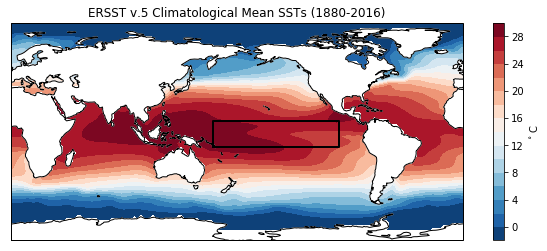

In [5]:
plt.figure(figsize=(11, 4))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)
clevels = np.arange(-2, 31, 2)
plt.contourf(sst_global['lon'], sst_global['lat'], sst_global.mean(dim='time'), clevels, 
             cmap='RdBu_r', transform=ccrs.PlateCarree())
cb = plt.colorbar()
cb.set_label(f'{DEGREE} C')
cf = cfeature.NaturalEarthFeature('physical', 'land', '110m')
ax.add_feature(cf, color='w')
ax.coastlines()
plt.plot([lon1, lon1, lon2, lon2, lon1], [lat1, lat2, lat2, lat1, lat1], 
         color='k', linewidth=2, transform=ccrs.PlateCarree())
plt.title('ERSST v.5 Climatological Mean SSTs (1880-2016)');

From the climatology above, we can see that the Pacific Ocean is characterized by warm temperatures in the western part of the ocean basin, and cool temperatures in the eastern part of the basin. The area with the warmest SSTs is known as the "western Pacific warm pool". During a strong El Ni&ntilde;o year, warm anomalies develop to the east of the western Pacific warm pool; these anomalies are associated with changes in the atmospheric and oceanic circulation of the tropical Pacific, and changes are often also observed in the weather in other areas of the world, far from the tropical Pacific Ocean.

Conversely, during a La Ni&ntilde;a year, the typical pattern of warm SSTs in the western Pacific and cool SSTs in the eastern Pacific is strengthened, and cool anomalies develop in the eastern Pacific. As with El Ni&ntilde;o, these anomalies are accompanied by other changes in the atmospheric and ocean circulation. For more background on El Ni&ntilde;o vs. La Ni&ntilde;a conditions, check out [this summary](https://www.ncdc.noaa.gov/teleconnections/enso/enso-tech.php).

For principal component analysis, we will use SSTs within the equatorial Pacific domain defined above. Extract SST data for this domain and define the edges of each grid cell in the domain, to use in `pcolormesh` plots.

In [6]:
sst = sst_global.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))

lat_res, lon_res = 2, 2
lat_bnds = sst['lat'].values - lat_res/2
lat_bnds = np.concatenate([lat_bnds, [lat_bnds[-1] + lat_res]])
lon_bnds = sst['lon'].values - lon_res/2
lon_bnds = np.concatenate([lon_bnds, [lon_bnds[-1] + lon_res]])
sst.attrs['lat_bnds'] = lat_bnds
sst.attrs['lon_bnds'] = lon_bnds

Plot climatological mean SSTs over the domain.

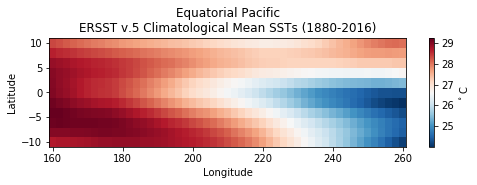

In [7]:
plt.figure(figsize=(8, 2))
plt.pcolormesh(sst.attrs['lon_bnds'], sst.attrs['lat_bnds'], sst.mean(dim='time'), cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label(f'{DEGREE} C')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Equatorial Pacific\nERSST v.5 Climatological Mean SSTs (1880-2016)');

## Data exploration

### Compare a strong El Ni&ntilde;o year and a strong La Ni&ntilde;a year


First, define some utility functions for creating monthly plots.

In [8]:
def colorbar_multiplot(**kwargs):
    """Create a single colorbar for all subplots in a figure."""
    cb = plt.colorbar(ax=plt.gcf().get_axes(), **kwargs)
    return cb

In [9]:
def plot_year(var, year=None, climits=None, suptitle=None, cmap='RdBu_r'):
    """Plot a pcolormesh of SSTs for each month in selected year (or mean climatology)."""
    fig, axes = plt.subplots(4, 3, figsize=(14, 6), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    months = range(1, 13)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for month, month_name, ax in zip(months, month_names, axes.ravel()):
        plt.sca(ax)
        if year is not None:
            var_plot = var.where((var['year'] == year) & (var['month'] == month), drop=True).squeeze()
        else:
            var_plot = var.where(var['month'] == month, drop=True).squeeze()
        plt.pcolormesh(var.attrs['lon_bnds'], var.attrs['lat_bnds'], var_plot, cmap=cmap)
        plt.clim(climits)
        plt.title(month_name)
    cb = colorbar_multiplot(orientation='vertical', shrink=0.7, extend='both')
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize='larger', fontweight='bold')

Plot SSTs in our domain during a strong El Ni&ntilde;o year (1997) and a strong La Ni&ntilde;a year (1988), using the same colour scale (22-30 $^{\circ}$C).

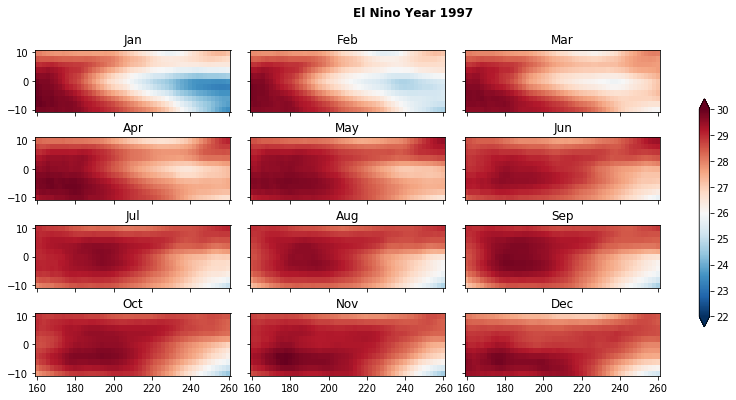

In [10]:
year = 1997
climits = 22, 30
plot_year(sst, year, climits=climits, suptitle=f'El Nino Year {year}')

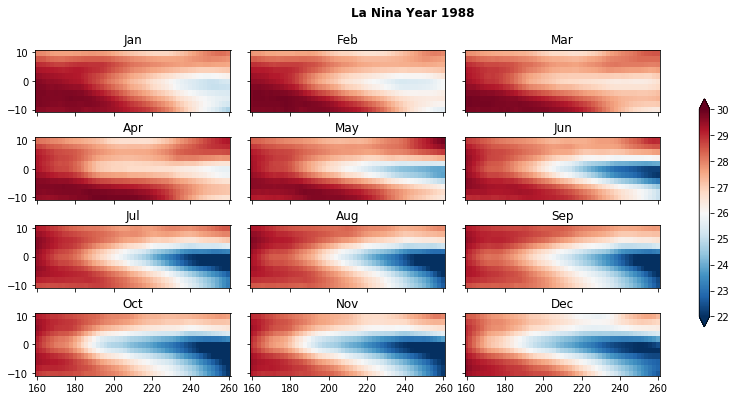

In [11]:
year = 1988
plot_year(sst, year, climits=climits, suptitle=f'La Nina Year {year}')

## Pre-processing for PCA

### Monthly climatology

Reshape the data to unstack the `year` and `month` dimensions.

In [12]:
print('*** Initial shape: ' + str(sst.shape))
dims = ['year', 'month', 'lat', 'lon']
sst_unstacked = sst.unstack('time').transpose(*dims)
print('*** Unstacked shape: ' + str(sst_unstacked.shape))
sst_unstacked

*** Initial shape: (1644, 11, 51)
*** Unstacked shape: (137, 12, 11, 51)


<xarray.DataArray 'sst' (year: 137, month: 12, lat: 11, lon: 51)>
array([[[[29.29714 , ..., 24.4831  ],
         ...,
         [27.065062, ..., 27.251913]],

        ...,

        [[29.335146, ..., 22.931911],
         ...,
         [27.720692, ..., 27.435339]]],


       ...,


       [[[29.876616, ..., 24.909698],
         ...,
         [27.995579, ..., 28.923567]],

        ...,

        [[30.205935, ..., 24.114834],
         ...,
         [28.935421, ..., 27.882864]]]], dtype=float32)
Coordinates:
  * lat       (lat) float64 -10.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 8.0 10.0
    lev       float64 0.0
  * lon       (lon) float64 160.0 162.0 164.0 166.0 168.0 170.0 172.0 174.0 ...
    datetime  (month, year) datetime64[ns] 1880-01-01 1881-01-01 1882-01-01 ...
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year      (year) int64 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 ...
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_

Now we can easily compute the climatology by taking the mean along the `year` dimension.

In [13]:
climatology = sst_unstacked.mean(dim='year', keep_attrs=True)
climatology

<xarray.DataArray 'sst' (month: 12, lat: 11, lon: 51)>
array([[[29.436424, 29.424566, ..., 24.053421, 23.929878],
        [29.528336, 29.500689, ..., 24.382046, 24.33456 ],
        ...,
        [28.16714 , 28.106705, ..., 26.851763, 26.780846],
        [27.730059, 27.660032, ..., 27.167337, 27.025072]],

       [[29.372215, 29.364658, ..., 25.125797, 25.09248 ],
        [29.396029, 29.365904, ..., 25.562016, 25.58702 ],
        ...,
        [28.01504 , 27.96433 , ..., 27.088783, 27.032051],
        [27.511543, 27.44593 , ..., 27.36476 , 27.271168]],

       ...,

       [[28.86558 , 28.87434 , ..., 22.920708, 22.631521],
        [29.202858, 29.21773 , ..., 23.035814, 22.800613],
        ...,
        [28.957722, 28.905884, ..., 27.202705, 27.140291],
        [28.724804, 28.667057, ..., 27.6733  , 27.5506  ]],

       [[29.268883, 29.262438, ..., 23.27782 , 23.047338],
        [29.4886  , 29.476246, ..., 23.482414, 23.32297 ],
        ...,
        [28.56604 , 28.511724, ..., 26.985952, 2

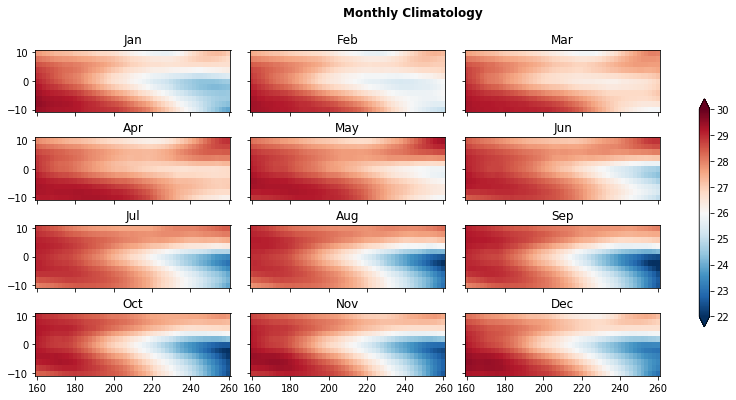

In [14]:
plot_year(climatology, climits=(22, 30), suptitle='Monthly Climatology')

### SST anomalies

Subtract the climalogical mean for each month to obtain the SST anomalies, and restack the `year` and `month` dimensions so we can apply a running mean in the next step.

In [15]:
sst_anom = sst_unstacked - climatology
sst_anom = sst_anom.stack(time=['year', 'month']).transpose('time', 'lat', 'lon')
for nm in ['lon_bnds', 'lat_bnds']:
    sst_anom.attrs[nm] = sst.attrs[nm]
sst_anom

<xarray.DataArray 'sst' (time: 1644, lat: 11, lon: 51)>
array([[[-0.139284, -0.158667, ...,  0.508278,  0.553223],
        [-0.159056, -0.164293, ...,  0.193069,  0.233232],
        ...,
        [-0.589106, -0.424841, ..., -0.202402, -0.27165 ],
        [-0.664997, -0.50845 , ...,  0.209698,  0.226841]],

       [[-0.069462,  0.024036, ...,  1.0441  ,  1.113665],
        [-0.061872,  0.028793, ...,  1.103052,  1.207865],
        ...,
        [-0.361326, -0.199539, ...,  0.544588,  0.46422 ],
        [-0.352013, -0.210537, ...,  0.535284,  0.556347]],

       ...,

       [[ 1.178242,  1.133589, ...,  1.153555,  1.1532  ],
        [ 1.187506,  1.115894, ...,  1.024469,  1.00795 ],
        ...,
        [ 0.833471,  0.822538, ...,  0.43469 ,  0.480749],
        [ 0.783979,  0.765751, ...,  0.556141,  0.621105]],

       [[ 0.937052,  0.92198 , ...,  1.052456,  1.067495],
        [ 0.994638,  0.968231, ...,  0.927139,  0.922571],
        ...,
        [ 0.780041,  0.789801, ...,  0.389261, 

### Smoothing

Smooth the anomalies with a 3-month running mean.

In [16]:
window = 3
sst_anom_sm = sst_anom.rolling(time=window, center=True).mean()
sst_anom_sm.attrs = sst_anom.attrs
sst_anom_sm

<xarray.DataArray (time: 1644, lat: 11, lon: 51)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-0.021134,  0.022465, ...,  0.829517,  0.876836],
        [-0.041738,  0.00312 , ...,  0.768911,  0.841526],
        ...,
        [-0.424145, -0.268925, ...,  0.129516,  0.048116],
        [-0.441862, -0.300433, ...,  0.210962,  0.203033]],

       ...,

       [[ 1.132284,  1.092325, ...,  1.025399,  1.033552],
        [ 1.155841,  1.098442, ...,  0.898734,  0.888838],
        ...,
        [ 0.841387,  0.839288, ...,  0.472653,  0.523788],
        [ 0.769938,  0.760915, ...,  0.635946,  0.70855 ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       

### Plot all the pre-processing steps for a single grid point

In [17]:
def extract_tseries(var, lon0, lat0):
    """Return a pandas.Series timeseries for a single grid point."""
    tseries = var.sel(lon=lon0).sel(lat=lat0)
    if 'time' in tseries.dims:
        tseries = tseries.swap_dims({'time' : 'datetime'})
    return tseries.to_series()

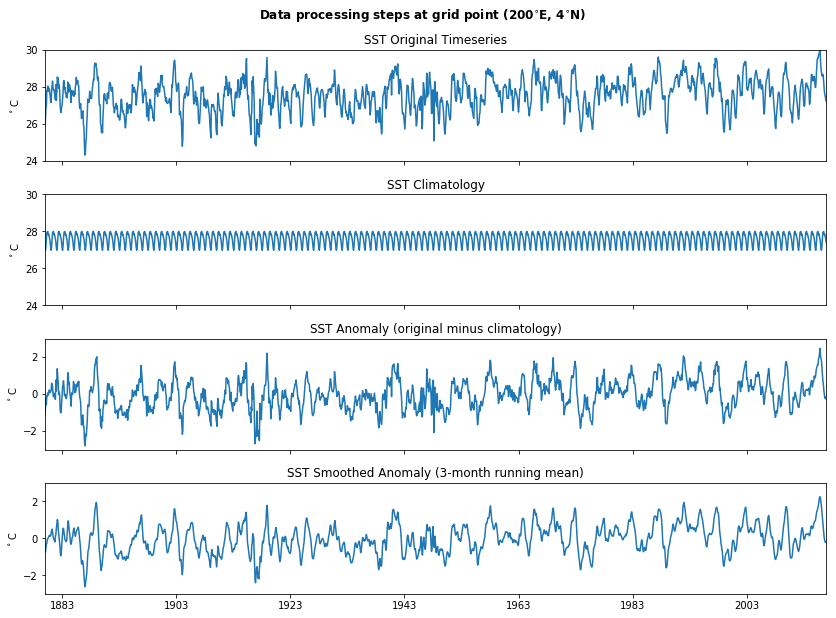

In [18]:
lon0, lat0 = 200, 4
df = extract_tseries(sst, lon0, lat0)
df = df.to_frame(name='SST Original Timeseries')

# Tile the climatology
nyears = int(len(df) / 12)
df['SST Climatology'] = np.tile(extract_tseries(climatology, lon0, lat0), nyears)

# SST anomalies and smoothed anomalies
df['SST Anomaly (original minus climatology)'] = extract_tseries(sst_anom, lon0, lat0)
df['SST Smoothed Anomaly (3-month running mean)'] = extract_tseries(sst_anom_sm, lon0, lat0)

xlims = df.index[0], df.index[-1]
times = df.index
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)
ylims_list = [(24, 30), (24, 30), (-3, 3), (-3, 3)]

for col, ax, ylims in zip(df.columns, axes, ylims_list):
    plt.sca(ax)
    plt.plot(times, df[col])
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title(col)
    plt.ylabel(f'{DEGREE} C')
plt.suptitle(f'Data processing steps at grid point ({lon0}{DEGREE}E, {lat0}{DEGREE}N)', 
             fontsize='larger', fontweight='bold', y=0.94);

### Plot the smoothed SST anomalies
A strong El Ni&ntilde;o year vs. a strong La Ni&ntilde;a year, using the same colour scale.

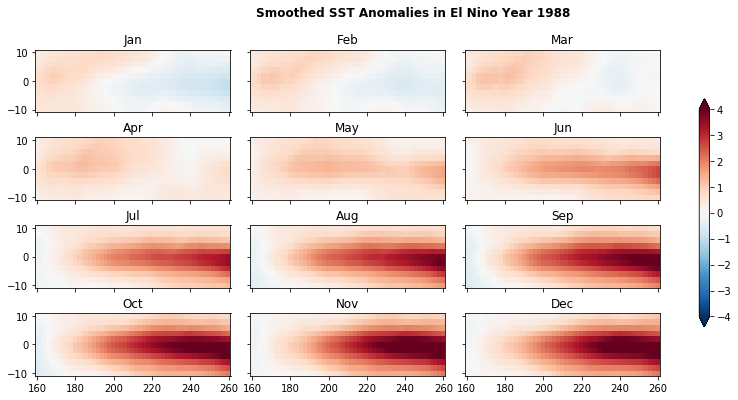

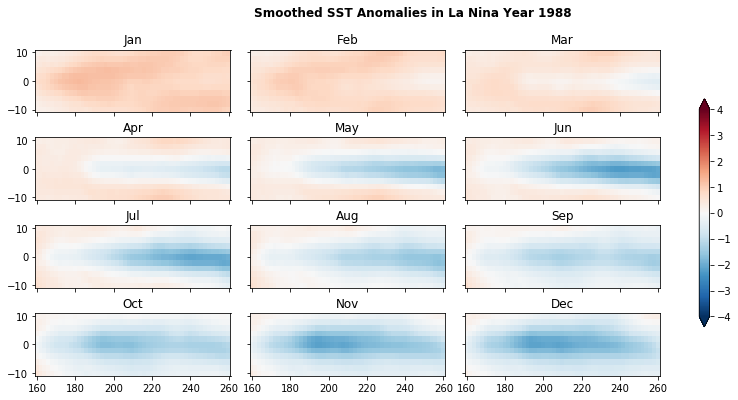

In [19]:
climits_anom = -4, 4
plot_year(sst_anom_sm, year=1997, climits=climits_anom, suptitle=f'Smoothed SST Anomalies in El Nino Year {year}')
plot_year(sst_anom_sm, year=1988, climits=climits_anom, suptitle=f'Smoothed SST Anomalies in La Nina Year {year}')

### Create 2-dimensional data array for input to PCA

For PCA, we want the data as a 2-dimensional array with the monthly measurements for rows and grid points for columns. 

First, remove the first and last months (which are NaNs due to the 3-month rolling mean) and stack the `lat`, `lon` dimensions. Then do some additional wrangling to convert multiilevel indexes into flat indexes, so that the data can be saved in `netcdf` format, and add some more metadata in the attributes.

In [20]:
data = sst_anom_sm[1:-1, :, :].stack(pt=['lat', 'lon'])

for nm in ['year', 'month', 'lat', 'lon']:
    data.coords[nm + '_vals'] = data[nm]
data.coords['pt_vals'] = xr.DataArray(np.arange(len(data['pt'])), dims='pt')
data = data.swap_dims({'time' : 'datetime', 'pt' : 'pt_vals'}).drop(['lev', 'pt', 'time'])
names_map = {nm : nm.replace('_vals', '') for nm in list(data.coords)}
data = data.rename(names_map)
data.attrs['data_source'] = 'ERSST v.5 monthly SSTs'
data.attrs['description'] = 'Anomalies from the 1880-2016 monthly climatology'
data.attrs['smoothing'] = 'Centered 3-month running mean'
data

<xarray.DataArray (datetime: 1642, pt: 561)>
array([[-0.021134,  0.022465,  0.085059, ...,  0.076836,  0.210962,  0.203033],
       [ 0.041402,  0.086643,  0.152017, ...,  0.231674,  0.353887,  0.346819],
       [ 0.071683,  0.07767 ,  0.122265, ..., -0.005128,  0.064588,  0.01059 ],
       ...,
       [ 1.153078,  1.116285,  1.081956, ...,  0.551089,  0.669486,  0.782111],
       [ 1.209536,  1.160529,  1.118472, ...,  0.584881,  0.692617,  0.787767],
       [ 1.132284,  1.092325,  1.057774, ...,  0.55231 ,  0.635946,  0.70855 ]],
      dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 1880-02-01 1880-03-01 1880-04-01 ...
    year      (datetime) int64 1880 1880 1880 1880 1880 1880 1880 1880 1880 ...
    month     (datetime) int64 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 ...
    lat       (pt) float64 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 ...
    lon       (pt) float64 160.0 162.0 164.0 166.0 168.0 170.0 172.0 174.0 ...
  * pt        (pt) int32 0 1 2 3

#### Save the data to file

In [21]:
savefile = 'data/ERSST_v5_1880-2016_anom.nc'
print('Saving to ' + savefile)
data.to_netcdf(savefile)

Saving to data/ERSST_v5_1880-2016_anom.nc


Next, see part 2 for the principal component analysis.